<a href="https://colab.research.google.com/github/AlmiraRahman/tugasMachineLearning/blob/main/Week9_4_4_Model_Selection%2C_Underfitting%2C_and_Overfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 933 kB/s 


In [2]:
import math
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l

In [3]:
max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
# Convert from NumPy ndarrays to tensors
true_w, features, poly_features, labels = [tf.constant(x, dtype=
    tf.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 0.567182 ],
        [-0.0832741]], dtype=float32)>,
 <tf.Tensor: shape=(2, 20), dtype=float32, numpy=
 array([[ 1.00000000e+00,  5.67182004e-01,  1.60847709e-01,
          3.04099731e-02,  4.31199744e-03,  4.89137426e-04,
          4.62383250e-05,  3.74650654e-06,  2.65618866e-07,
          1.67393601e-08,  9.49426315e-10,  4.89543198e-11,
          2.31383402e-12,  1.00951155e-13,  4.08983421e-15,
          1.54645346e-16,  5.48200344e-18,  1.82899624e-19,
          5.76318745e-21,  1.72040845e-22],
        [ 1.00000000e+00, -8.32741037e-02,  3.46728833e-03,
         -9.62451159e-05,  2.00368140e-06, -3.33709558e-08,
          4.63156097e-10, -5.50984432e-12,  5.73534208e-14,
         -5.30672759e-16,  4.41912970e-18, -3.34544604e-20,
          2.32157523e-22, -1.48713159e-24,  8.84568222e-27,
         -4.91077529e-29,  2.55587760e-31, -1.25199075e-33,
          5.79213398e-36, -2.53860407e-38]], dtype=float32)>,
 <tf.Tensor: 

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(tf.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = tf.losses.MeanSquaredError()
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1, use_bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    test_iter = d2l.load_array((test_features, test_labels), batch_size,
                               is_train=False)
    trainer = tf.keras.optimizers.SGD(learning_rate=.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net.get_weights()[0].T)

weight: [[ 5.0156345  1.2067835 -3.4096053  5.5948863]]


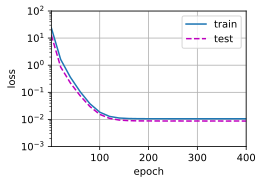

In [7]:
# Pick the first four dimensions, i.e., 1, x, x^2/2!, x^3/3! from the
# polynomial features
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[2.9457548 4.115905 ]]


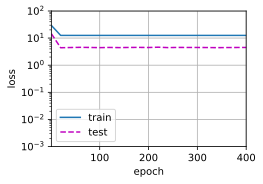

In [8]:
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0210347   1.3304561  -3.427653    5.0724797   0.00882567  1.0824187
   0.03915558  0.318318    0.4174551  -0.5278636   0.06171143 -0.33188894
   0.5113186  -0.45735934 -0.14374606 -0.3785737  -0.34973922  0.04435946
  -0.2274808   0.13996679]]


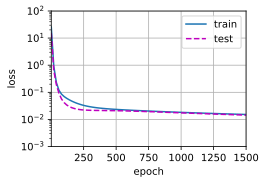

In [9]:
# Pick all the dimensions from the polynomial features
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)